In [1]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# Data set
molecules = pd.read_csv("../tests/test_data/molecules.tsv", sep="\t")
species = pd.read_csv("../tests/test_data/loading_tree.tsv", sep="\t")

In [2]:
import networkx as nx

g_molecules = nx.DiGraph()
for _, row in molecules.iterrows():
    g_molecules.add_edge(row["parent"], row["child"], weight=row["length"])

g_species = nx.DiGraph()
for _, row in species.iterrows():
    g_species.add_edge(row["parent"], row["child"], weight=row["length"])

In [3]:
from typing import List


def get_linear_index(coord: List[int], dimensions: List[int]) -> int:
    index = coord[-1]
    prod = 1
    for i in range(len(dimensions) - 1, 0, -1):
        prod *= dimensions[i]
        index += prod * coord[i - 1]
    return index


node_idx_species = {node: i for i, node in enumerate(g_species.nodes())}
nodes_idx_molecules = {node: i for i, node in enumerate(g_molecules.nodes())}

molecules_leaf_indices = [None for i in nodes_idx_molecules]
mol_internal_nodes_indices = [None for i in nodes_idx_molecules]
molecule_leaves = []
mol_internal_nodes = []

i = 0
j = 0
for m, molecules_idx in nodes_idx_molecules.items():
    mol_successors = [child for child in g_molecules.successors(m)]
    mol_parent = [par for par in g_molecules.predecessors(m)]
    if not mol_successors:
        molecule_leaves.append(molecules_idx)
        molecules_leaf_indices[molecules_idx] = i
        i += 1
    if mol_successors:
        mol_internal_nodes.append(molecules_idx)
        mol_internal_nodes_indices[molecules_idx] = j
        j += 1


species_leaf_indices = [None for i in node_idx_species]
species_internal_nodes_indices = [None for i in node_idx_species]
species_leaves = []
species_internal_nodes = []
i = 0
j = 0
for s, species_idx in node_idx_species.items():
    species_successors = [child for child in g_species.successors(s)]
    species_parent = [par for par in g_species.predecessors(s)]
    if not species_successors:
        species_leaves.append(species_idx)
        species_leaf_indices[species_idx] = i
        i += 1

    if species_successors:
        species_internal_nodes.append(species_idx)
        species_internal_nodes_indices[species_idx] = j
        j += 1

In [4]:
Y = pd.read_csv("../build/acol_simulated_Y.txt", sep="\t", index_col=0)
Z_molecules = pd.read_csv("../build/acol_simulated_Z_molecules.txt", sep="\t")
Z_species = pd.read_csv("../build/acol_simulated_Z_species.txt", sep="\t")

In [5]:
matrix = np.zeros((len(nodes_idx_molecules), len(node_idx_species)), dtype=np.uint8)

In [6]:
i = 0
for m, molecules_idx in nodes_idx_molecules.items():
    mol_successors = [child for child in g_molecules.successors(m)]
    mol_parent = [par for par in g_molecules.predecessors(m)]
    for s, species_idx in node_idx_species.items():
        species_successors = [child for child in g_species.successors(s)]
        species_parent = [par for par in g_species.predecessors(s)]

        # now we need to check if the four lists created are not empty that means they are all internal nodes so we continue
        if mol_successors and mol_parent and species_successors and species_parent:
            i += 1
            continue

        # if they are both roots we also continue
        if not mol_parent and not species_parent:
            i += 1
            continue

        # if mol is root and species is internal node, we also continue
        if not mol_parent and species_parent and species_successors:
            i += 1
            continue

        # now the opposite : if the mol is internal node and the species is root
        if mol_parent and mol_successors and not species_parent:
            i += 1
            continue

        # easy case : if both nodes are a leaf:
        if not mol_successors and not species_successors:
            matrix[molecules_idx, species_idx] = Y["state"][
                get_linear_index(
                    [
                        molecules_leaf_indices[molecules_idx],
                        species_leaf_indices[species_idx],
                    ],
                    [len(molecule_leaves), len(species_leaves)],
                )
            ]
            continue

        # case : mol is a leaf and species is an internal node -> take Z of species
        if not mol_successors and species_successors:
            matrix[molecules_idx, species_idx] = Z_species["state"][
                get_linear_index(
                    [
                        molecules_leaf_indices[molecules_idx],
                        species_internal_nodes_indices[species_idx],
                    ],
                    [len(molecule_leaves), len(species_internal_nodes)],
                )
            ]
            continue

        # final case : mol is an internal node and species is a leaf -> take Z of molecule
        if mol_successors and not species_successors:
            matrix[molecules_idx, species_idx] = Z_molecules["state"][
                get_linear_index(
                    [
                        mol_internal_nodes_indices[molecules_idx],
                        species_leaf_indices[species_idx],
                    ],
                    [len(mol_internal_nodes), len(species_leaves)],
                )
            ]

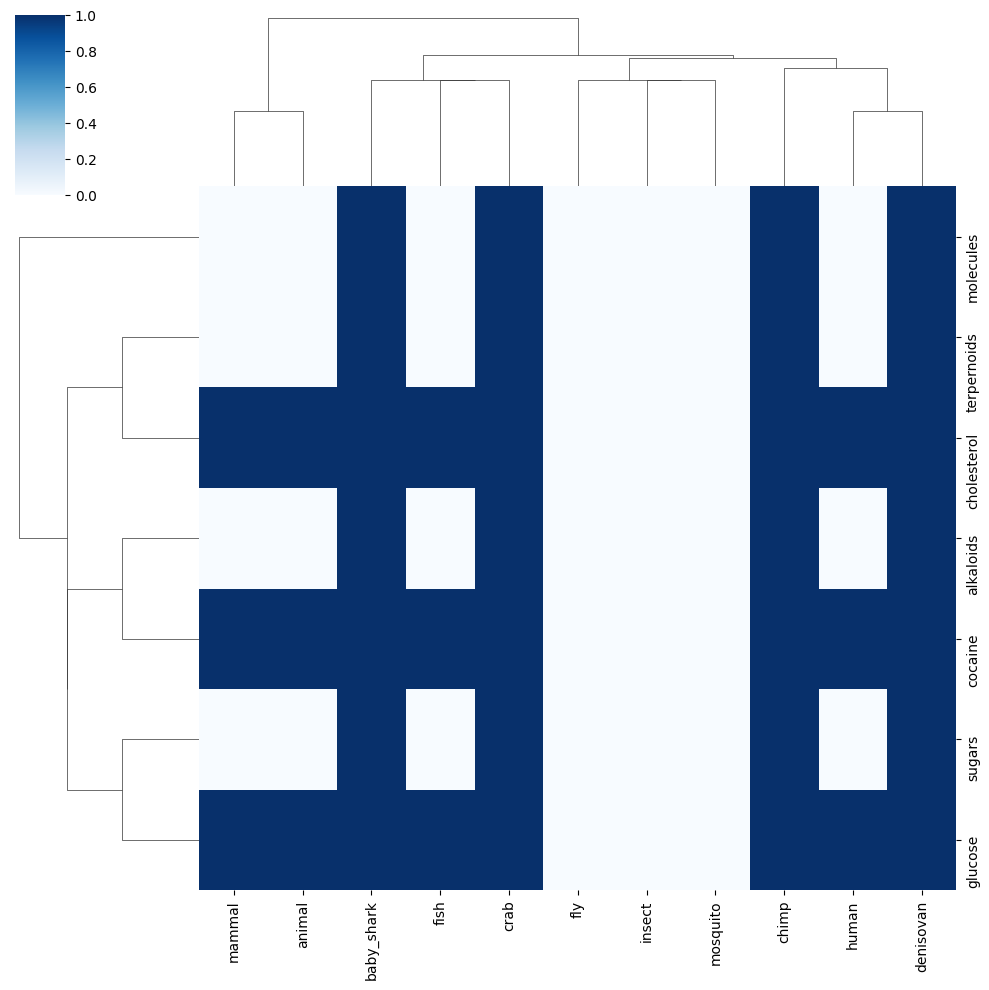

In [ ]:
import scipy.cluster.hierarchy as sch

dist_matrix_molecules = np.zeros((len(nodes_idx_molecules), len(nodes_idx_molecules)))
for i, node1 in enumerate(g_molecules.nodes()):
    for j, node2 in enumerate(g_molecules.nodes()):
        if i != j:
            try:
                dist_matrix_molecules[i, j] = nx.shortest_path_length(
                    g_molecules, source=node1, target=node2
                )
            except nx.NetworkXNoPath:
                dist_matrix_molecules[i, j] = 200000  # No connection

# Convert distance matrix into a linkage matrix
linkage_molecules = sch.linkage(dist_matrix_molecules, method="average")

dist_matrix_species = np.zeros((len(node_idx_species), len(node_idx_species)))
for i, node1 in enumerate(g_species.nodes()):
    for j, node2 in enumerate(g_species.nodes()):
        if i != j:
            try:
                dist_matrix_species[i, j] = nx.shortest_path_length(
                    g_species, source=node1, target=node2
                )
            except nx.NetworkXNoPath:
                dist_matrix_species[i, j] = 200000  # No connection

# Convert distance matrix into a linkage matrix
linkage_species = sch.linkage(dist_matrix_species, method="average")


# Create a clustermap using the computed linkage matrix
sns.clustermap(
    matrix,
    row_linkage=linkage_molecules,
    col_linkage=linkage_species,
    cmap="Blues",
    xticklabels=g_species.nodes(),
    yticklabels=g_molecules.nodes(),
)